# Usage Guide : pygtm
## March 2nd, 2020

In [1]:
import sys
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cmocean
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
sys.path.insert(0, '../')
from pygtm.physical import physical_space
from pygtm.matrix import matrix_space
from pygtm.segments import split_trajectories

# Load drifter trajectories
## Using the drogued drifters in GDP database in the North Atlantic ([*download* data here](https://miamiedu-my.sharepoint.com/:u:/g/personal/pxm498_miami_edu/EfaPVkKsPABJrJtKyctKrAUBpp7XzNHHrOLUhFow3pMkZw?e=MXzrcG)) and ([notebook](https://github.com/philippemiron/notebooks/blob/master/gdp.ipynb) for more info)

In [3]:
filename = 'gdp-north-atlantic-drogued.mat'
with h5py.File(filename, 'r') as f:
    d_id = f['id'][0]
    x = f['x'][0]  # [deg]
    y = f['y'][0]  # [deg]
    t = f['t'][0]  # [day]
del f

# drifter IDs are reused in the GDP so you make sure
# there isn't more than 10d before data points of a
# same drifter ID
I = np.where(abs(np.diff(d_id, axis=0)) > 0)[0]
I = np.insert(I, [0, len(I)], [-1, len(d_id) - 1])
max_id = np.max(d_id)

for i in range(0, len(I) - 1):
    range_i = np.arange(I[i] + 1, I[i + 1] + 1)
    t_diff = np.diff(t[range_i])

    # if there is a big gap, I changed the id and
    # treat the new segments as another drifters
    jump = np.where(t_diff > 10)[0]  # 10 days
    if len(jump) > 0:
        jump = np.insert(jump, [0, len(jump)], [-1, len(range_i) - 1])

        for j in range(0, len(jump) - 1):
            range_j = np.arange(jump[j] + 1, jump[j + 1] + 1)
            d_id[range_i[range_j]] = np.ones(len(range_j)) * (max_id + 1)  # range modification
            max_id += 1

# Parameters
- T: Transition time [day]
- spatial_dis : number of bin in the the meridional direction (the number in the zonal direction is fixed to have almost square bin)
- lon : min and max longitude value of the initial domain
- lat : min and max latitude value of the initial domain

In [4]:
T = 5  # transition time [days]
spatial_dis = 75
lon = [-98, 35]
lat = [-5, 80]

# We can already create the spatial domain structures
- nx: number of points on the meridional direction
- ny: number of points of the zonal direction 
- N0: number of initial bin in the domain
- bins ([N0, 4]): each bin or cell of the domain, every row contains the indices in the coords array of the four points forming this cell
- coords ([nx*ny,2]): coordinates (longitude, latitde) of each points on the domain
- id ([ny-1, nx-1]): rectangle with the indices of each elements on the initial domain

In [5]:
# create the grid and bins
d = physical_space(lon, lat, spatial_dis)

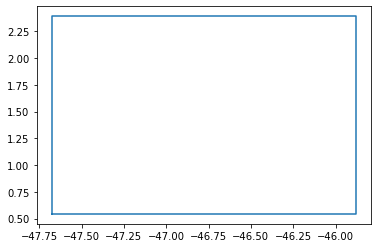

In [6]:
# for example to plot 1 element
el_id = 250
b1 = d.bins[el_id]

# reorder (0, 1, 3, 2, 0) for a close loop
b1 = b1[np.array([0,1,3,2,0])]

plt.plot(d.coords[b1,0], d.coords[b1,1])

# The following part takes the input trajectories and generate 4 vectors
- x0, y0: initial lon, lat of a segment (at t0)
- xT, yT: final lon, lat of a segment (t0 + T)

In [7]:
# split trajectories into segments
trajectory_segments = split_trajectories(T, x, y, t, d_id)

In [8]:
# the trajectory is interpolated daily
print(trajectory_segments.x0[0:6])
# and as you can see from x0 and xT, x0[6] is equal to xT[0] which means 
# that x0[0] and xT[0] are T days apart
print(trajectory_segments.xT[0:6])

[-52.732 -52.972 -53.038 -53.195 -53.266 -53.314]
[-53.314 -53.395 -53.689 -53.6   -53.557 -53.885]


# Create the matrix object and fill the transition matrix

- N : number of bin in the domain after removing empty bin (land or no data)
- B [N] : list of list of particle at the initial time in each bin
- M [N] : number of particles per bins at time t
- P [N,N]: 
- eigL [Nv] : eigenvalues (real eigenvalues in decreasing order)
- eigR [Nv] : eigenvalues 
- L [N, Nv] : left eigenvectors
- R [N, Nv] : right eigenvectors
- fi [N] : flow inside of the domain
- fo [N] : flow outisde of the domain

In [9]:
# create matrix object
tm = matrix_space(d)
tm.fill_transition_matrix(trajectory_segments)

1596 empty bins out of 3404 bins. (46.89%)


In [10]:
# calculate the eigenvectors of the transition matrix
# this takes the most time, only do if you want to look
# at the eigenstructures or calculate the lagrangian geography
tm.left_and_right_eigenvectors(100)

In [11]:
# asked for 100 vectors but we keep only the real one (44 in this case)
tm.R.shape

(1808, 44)

In [12]:
# postprocessing
clusters = tm.lagrangian_geography(np.arange(1, 30), 6)
multiplicity = np.where(tm.eigL - 1 < -1e-11)[0][0] - 1

# Plotting section

In [13]:
# some variables useful  to keep everything uniform
font = {'family': 'DejaVu Sans',  # ['serif', 'sans-serif', 'cursive', 'fantasy', 'monospace']
        'style': 'normal',  # ['normal', 'italic', 'oblique']
        'weight': 'normal',  # ['light', 'normal', 'medium', 'semibold', 'bold', 'heavy', 'black']
        'size': 8}
matplotlib.rc('font', **font)

# other global settings
matplotlib.rcParams['xtick.major.pad'] = '1'
matplotlib.rcParams['ytick.major.pad'] = '1'

# To plot, there is a function in the domain object to convert a vector value of size N to a 2d matrix that can be plot with pcolormesh, contour, contourf, etc.

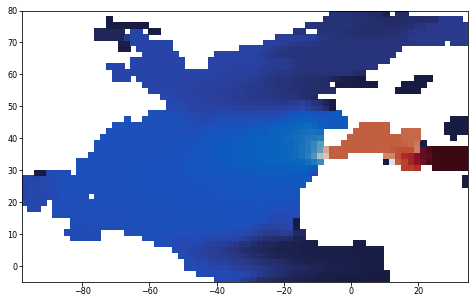

In [14]:
# simple plot
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
p = ax.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.R[:, multiplicity + 1]), cmap=cmocean.cm.balance)

In [15]:
# simple function to fix the axis and make plot prettier
def geo_map(ax):
    # ticks
    ax.set_xticks([-90, -60, -30, 0, 30], crs=ccrs.PlateCarree())
    ax.set_yticks([-10, 20, 50, 80], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # add land and coastline
    ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

# Left and right eigenvectors

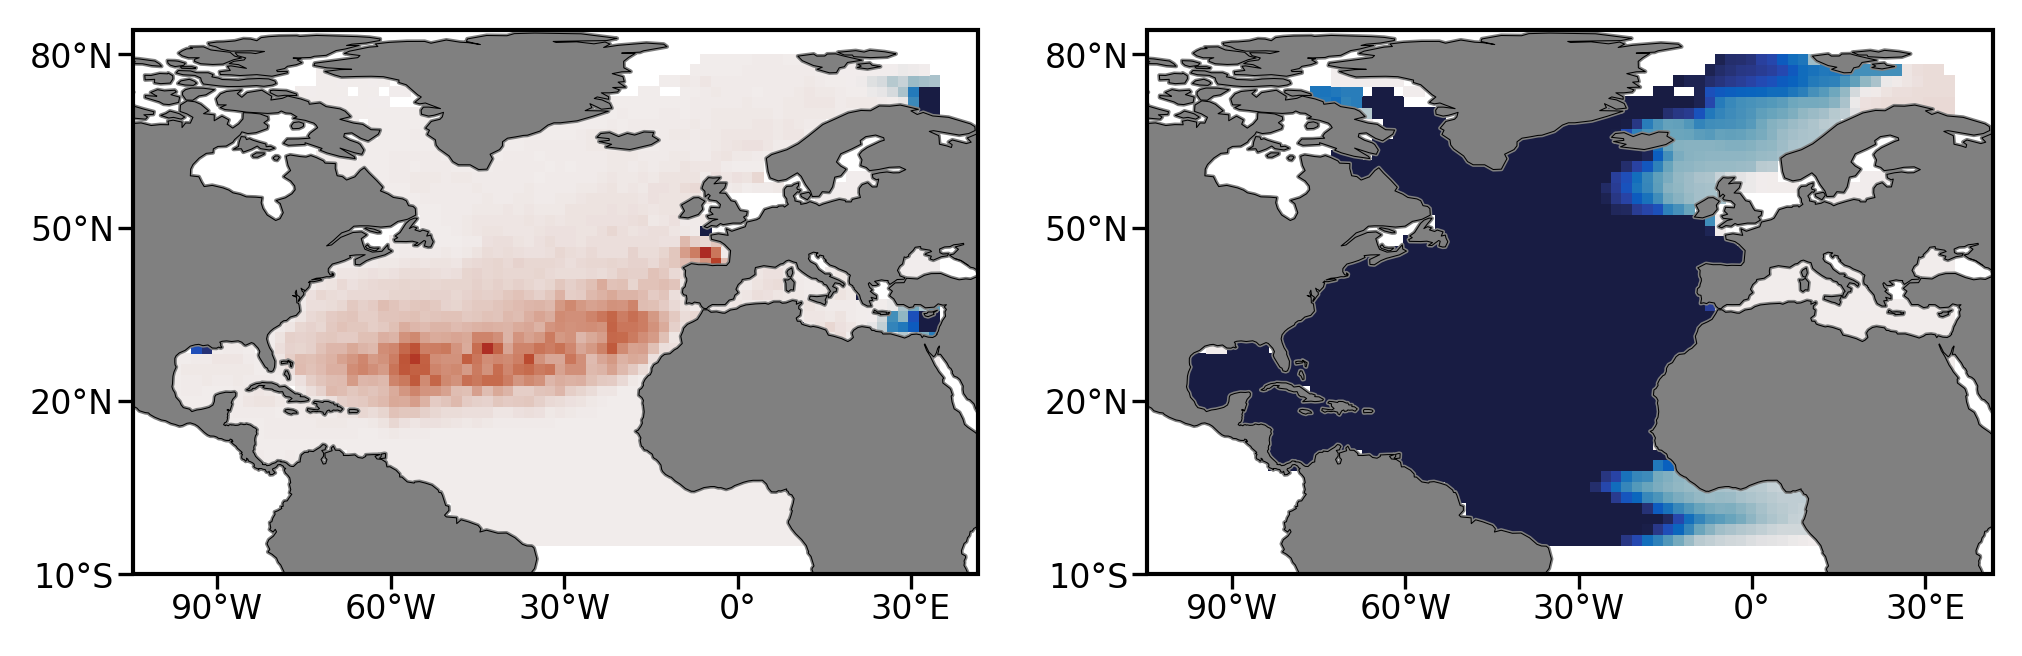

In [16]:

vector_num = multiplicity + 3
fig = plt.figure(figsize=(8, 4), dpi=300)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree(), aspect='equal')
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree(), aspect='equal')
ax1.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.L[:, vector_num]), cmap=cmocean.cm.balance, vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree())
ax2.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.R[:, vector_num]), cmap=cmocean.cm.balance, vmin=-0.25, vmax=0.25, transform=ccrs.PlateCarree())
geo_map(ax1)
geo_map(ax2)

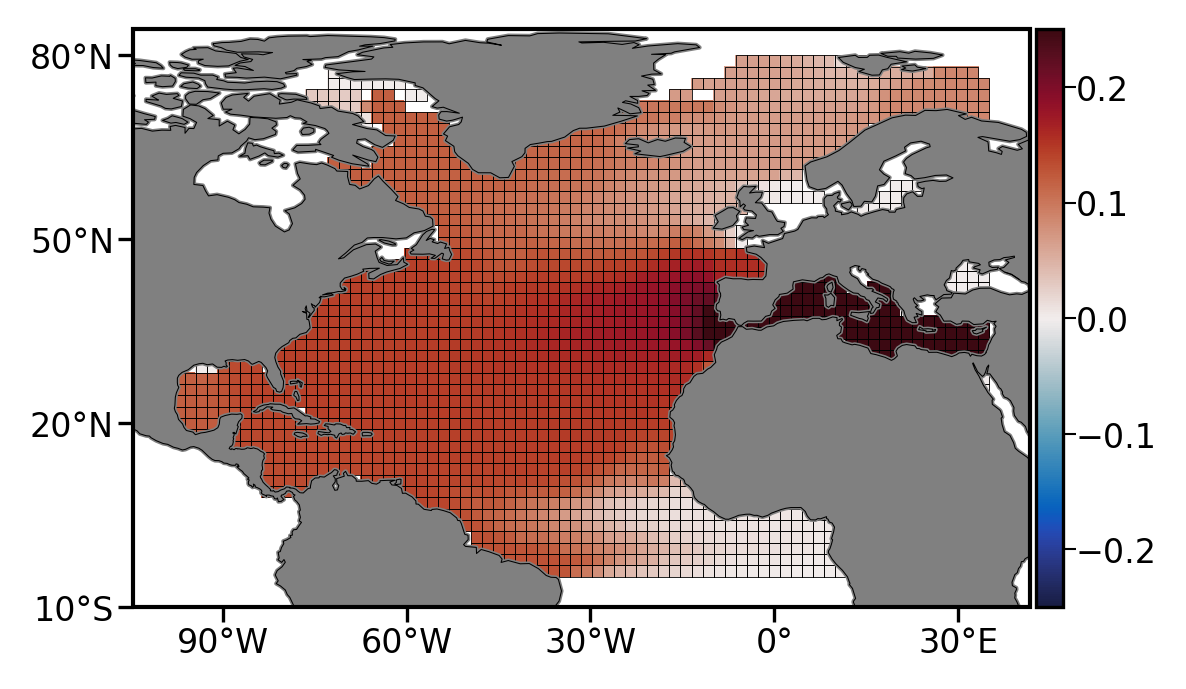

In [17]:
# geophysical plot with axis label, continent and colorbar
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
p = ax.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.R[:, multiplicity + 1]), cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
p.set_clim([-0.25, 0.25])
# available function to plot the boundaries of each bin
d.bins_contours(ax)
geo_map(ax)
# colorbar's magic
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)

# Plotting the vector fi and fo to visualize where drifters gets in and out of the domain. Those vectors are probability distribution, so the sum(fi)=sum(fo)=1.

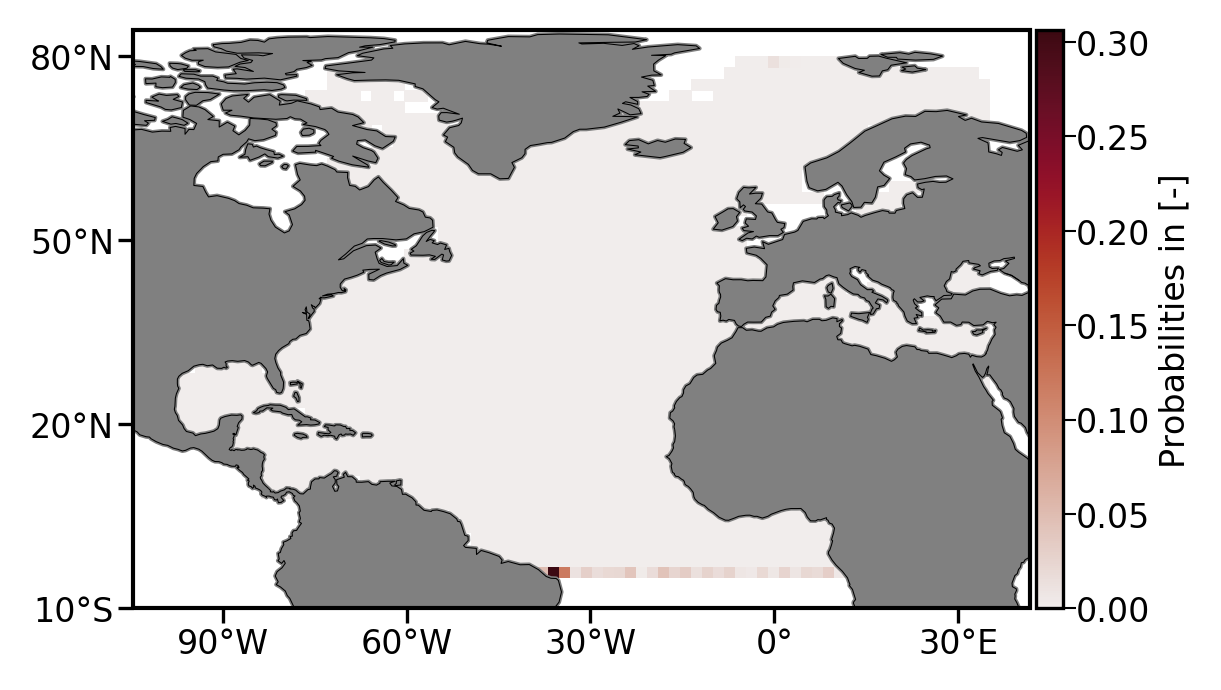

In [18]:
# flow in and out
fig = plt.figure(figsize=(4, 4), dpi=300)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')
p1 = ax1.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.fi), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p1, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Probabilities in [-]', size=8, labelpad=2)
geo_map(ax1)

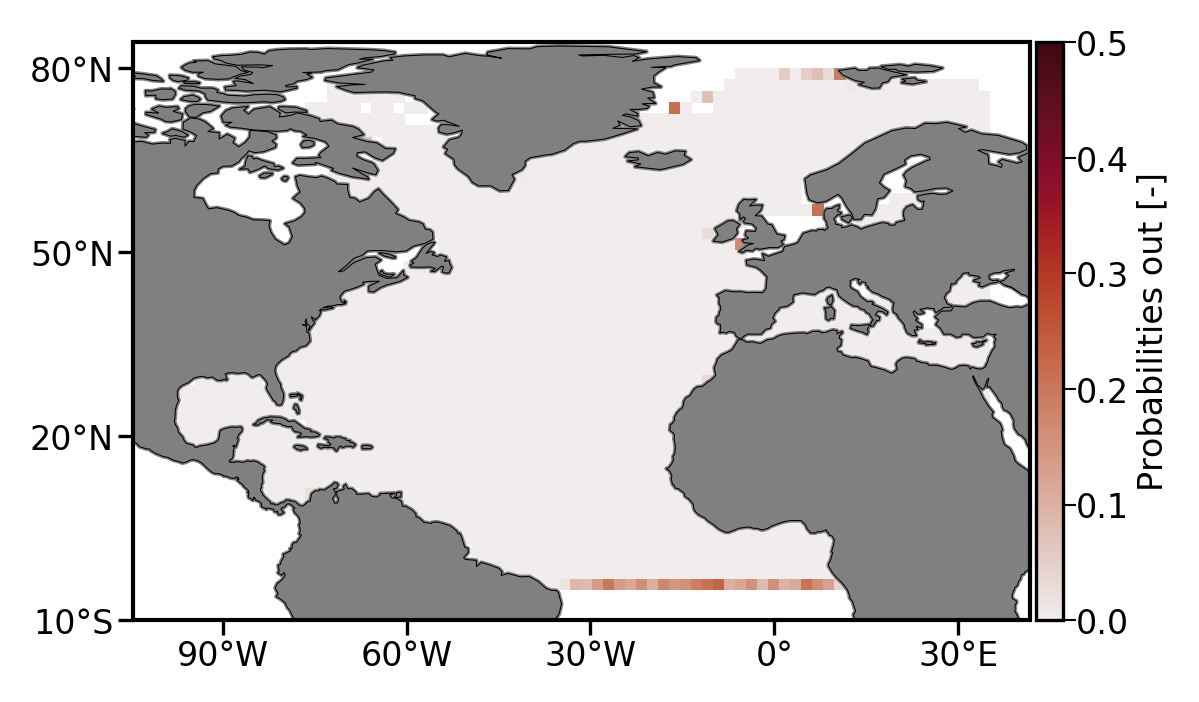

In [19]:
fig = plt.figure(figsize=(4, 4), dpi=300)
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')
p2 = ax2.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.fo), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p2, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Probabilities out [-]', size=8, labelpad=2)
geo_map(ax2)

# Lagrangian Geography
## Calculated above from a set of top eigenvectors, we plot the clusters value extracted from K-Means.

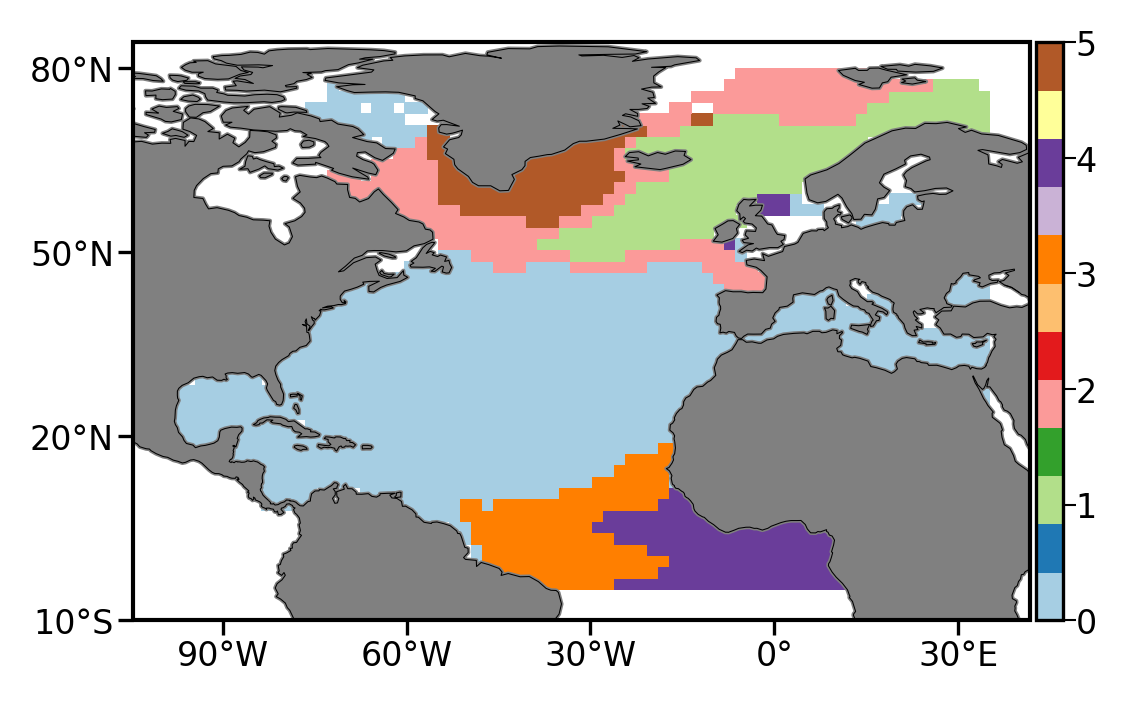

In [20]:
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')
p = ax.pcolormesh(d.vx, d.vy, d.vector_to_matrix(clusters), cmap='Paired', transform=ccrs.PlateCarree())
geo_map(ax)
# colorbar's magic
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)

# Pushforward or evolve an initial density
- find the initial location using `find_element(lon, lat)`. The initial distribution can be set on multiple bins.
- normalize the initial distribution sum(d0)=1
- push_formward(d0, k) performs d = d0 * P^k, for every multiplication by P, the distrution is evolve T days.

In [21]:
# pushforward from initial location
# ~ GS -65.290102 33.294395
time_evolution = 365  # days
density = np.zeros(tm.N)
initial_location = d.find_element([-65], [37])
density[initial_location] = 1
density /= np.sum(density)
evolved_density = tm.push_forward(density, int(time_evolution / T))

# Since we are using cartopy, we can easily change the projection (but sadly we lose the ticks...)

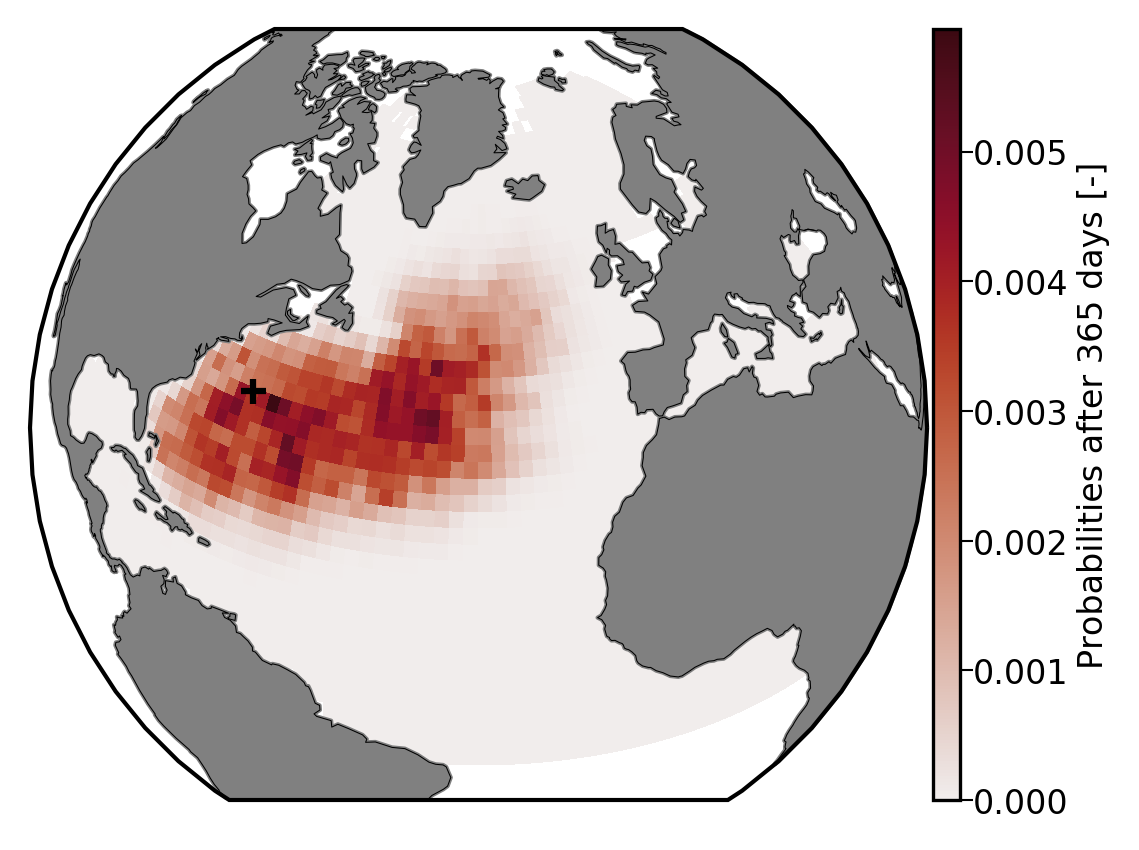

In [22]:
fig = plt.figure(figsize=(4, 4), dpi=300)
mid_lon = (lon[0]+lon[1])/2
mid_lat = (lat[0]+lat[1])/2

ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.NearsidePerspective(central_longitude=mid_lon, central_latitude=mid_lat), aspect='equal')
p1 = ax1.pcolormesh(d.vx, d.vy, d.vector_to_matrix(evolved_density), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
ax1.scatter(-65, 37, color='k', marker='+', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p1, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Probabilities after %d days [-]' % (time_evolution), size=8, labelpad=2)